In [13]:
import pandas as pd
import json
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib
import math
from helper import *

In [14]:
df = pd.read_csv('data/sample_data_example.csv')
print(len(df))
df.head()

428


,sessionid,accountid,browserdimensions,screendimensions,ip,requesttime,unixtime,accountemaildomain,devicefingerprint,deviceid,...,region,city,score,browserlanguage,browsertimezone,cardtype,paymentmethod,device_pointing_method,cart_info,shipping_info
0,wsc-2rVdbyevQfwRp6U75BD56NY9qq4x,!dlgeroy@gmail.com,1760x960 1745x868,1745x945,47.180.93.154,16-11-07 22:07,1478556458,gmail.com,d1-d3184e026f80ac,wcs-fuGREf1aGtqZiHsh9P21ZQxx,...,California,Los Angeles,0,en-US,480.0,NaN,NaN,mouse,"{""CartProduct"":{""all"":[{""productSKU"":""476058"",...","{""ShippingAddress"":{""shippingstate"":""CA"",""ship..."
1,wsc-NSVAWFqCGPMH9WcDQyPrRZeeRf4x,$guin@1010internet.com,1316x709 1301x620,1301x693,206.114.35.246,17-01-15 19:22,1484508135,1010internet.com,d1-87517afb7b65cdd5,wcs-dR63GkKgERjYM76noAG3kwxx,...,Michigan,Grand Rapids,0,en-US,300.0,NaN,NaN,mouse,"{""CartProduct"":{""productSKU"":""591215"",""product...","{""ShippingAddress"":{""shippingstate"":""MI"",""ship..."
2,wsc-4U0D5yRCzZZ1cXamKEuHWhX4KL0x,&amp;amp;atilde;&amp;amp;copy;valsherbrooke,1920x1080 1745x900,1920x1080,184.160.23.102,17-04-06 20:22,1491510169,NaN,d1-2acc077ad66a1f35,wcs-EWxz4CvUTpt5MONhbcnJpAxx,...,Quebec,Montreal,0,fr,300.0,NaN,NaN,mouse,"{""CartProduct"":{""all"":[{""productSKU"":""14336"",""...","{""ShippingAddress"":{""shippingstate"":""QC"",""ship..."
3,wsc-N8g5JCerZIejrlKxipgkVWvgqqwx,'adrienne_s@earthlink.net,1550x838 1312x698,1536x824,45.49.248.159,16-10-24 6:41,1477291292,NaN,d1-4d9c5566cbb7b37d,wcs-H9DeRNHcasRTL4KwcS8ajQxx,...,California,Santa Monica,0,en-US,480.0,NaN,NaN,mouse,"{""CartProduct"":{""all"":[{""productSKU"":""108230"",...","{""ShippingAddress"":{""shippingstate"":""CA"",""ship..."
4,wsc-8zzwFiCPl8ktn1yNsY2D6xqwmkox,*******7489,NaN,NaN,50.92.253.86,16-10-11 17:35,1476207349,NaN,d1-00000000,NaN,...,British Columbia,Kelowna,105,NaN,NaN,NaN,NaN,mouse,"{""CartProduct"":{""all"":[{""productSKU"":""572505"",...","{""ShippingAddress"":{""shippingstate"":""BC"",""ship..."


In [15]:
amounts= []
dates = []
for _, transaction in df.iterrows():
    if isinstance(get_date(transaction['shipping_info']), str):
        srt2date = datetime.datetime.strptime(get_date(transaction['shipping_info']),  '%Y/%m/%d').date()
        dates.append(srt2date)
        amounts.append(round(get_amount(transaction['cart_info']), 2))

In [16]:
len(amounts)

427

In [17]:
len(dates)

427

In [18]:
featuresdf = pd.DataFrame()
featuresdf['date'] = [d for d in dates]
featuresdf['value'] = amounts
featuresdf.head()

,date,value
0,2016-11-07,54.99
1,2017-01-15,71.70
2,2017-04-06,47.96
3,2016-10-24,96.99
4,2016-10-11,53.10


In [23]:
def control_chart(feature1, feature2, k=1, show=False):
    std = np.std(feature1)
    m = np.mean(feature1)
    
    ctrl_stdup = m + (k*std)
    ctrl_stddown = m - (k*std)
    
    out_val=[]
    out_dates=[]
    
    pos_val= []
    pos_dates= []
    
    for i, point in enumerate(feature1):
        if point >= ctrl_stdup or point <= ctrl_stddown:
            out_val.append(point)
            out_dates.append(feature2[i])
        else:
            pos_val.append(point)
            pos_dates.append(feature2[i])
    
    
    score = (len(out_val)/len(feature1))*100
    if show:
        #show plot
        print('the score is: ',score)
        if isinstance(out_dates[0], datetime.date):
            dates_list = feature2
            plot_dates = matplotlib.dates.date2num(dates_list)
            plt.plot_date(pos_dates, pos_val, c= 'b')
            plt.plot_date(out_dates, out_val, c='r')
        else:
            plt.plot(pos_dates, pos_val, c= 'b')
            plt.plot(out_dates, out_val, c='r')


        plt.plot((min(feature2), max(feature2)), (m, m), 'k-')
        plt.plot((min(feature2), max(feature2)), (ctrl_stdup, ctrl_stdup), 'k-', c='g')
        plt.plot((min(feature2), max(feature2)), (ctrl_stddown, ctrl_stddown), 'k-', c='g')
        plt.show()
        
    return score  

control_chart(featuresdf['value'], featuresdf['date'], k=2)

3.51288056206089

In [28]:
from sklearn.neighbors import LocalOutlierFactor

def lof(feature1 , feature2, show=False, n_neighbors= 15):
    # Generate train data
    #dates = data['date'].as_matrix()
    if isinstance(feature2[0], datetime.date):
        dates_dict = {d:i for i,d in enumerate(set(np.sort(dates)))}

        date2int = [dates_dict[d] for d in dates]
    else:
        date2int = feature2
    X = list(zip(feature1, date2int))
    
    # Generate some abnormal novel observations
    # fit the model
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, algorithm='auto')
    y_pred = clf.fit_predict(X)
    
    out_val=[]
    out_dates=[]
    
    pos_val= []
    pos_dates= []
    for i, pred in enumerate(y_pred):
        if pred == -1:
            out_val.append(feature1[i])
            out_dates.append(feature2[i])
        else:
            pos_val.append(feature1[i])
            pos_dates.append(feature2[i])

    score = (len(out_val)/len(y_pred))*100
    
    if show:
        print('witn a total score of:',score)
        if isinstance(out_dates[0], datetime.date):
            plt.plot_date(pos_dates, pos_val, c= 'b')
            plt.plot_date(out_dates, out_val, c='r')
        else:
            plt.plot(pos_dates, pos_val, c= 'b')
            plt.plot(out_dates, out_val, c='r')
        plt.figure(figsize=(500,500))
        plt.show()

    return score

lof(featuresdf['value'], featuresdf['date'])

10.070257611241217

In [29]:
from collections import Counter
def benfords(values, show=False):
    
    digits=[]
    for v in values:
        digits.append(int(str(v)[0]))
    
    d_count= Counter(digits)
    num= list(range(1,10))
    total_count=[d_count[i] for i in num]
    prc=[]
    for i in num:
        prc.append((d_count[i]/ len(digits))*len(digits))
        
    benford = [100*math.log10(1 + 1./i) for i in range(1,10)]
    
    error = abs(np.sum(np.array(benford) - np.array(prc)))

    score = (error/sum(benford))*100
    
    score = (1/(1+np.exp(-score)))*100
    
    index = np.arange(len(num))
    bar_width = 0.35
    if show:
        print('the total score of benfords is ', score)
        plt.bar(index, prc, bar_width, color='b', label='values')
        plt.bar(index + bar_width, benford, bar_width, color='r',label='benford')
        plt.xticks(index + bar_width / 2, (1,2,3,4,5,6,7,8,9))
        plt.show()
    
    return score

benfords(featuresdf['value'])

100.0

the total score of benfords is  100.0


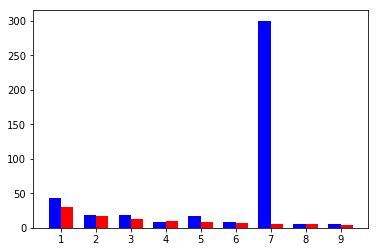

witn a total score of: 10.070257611241217


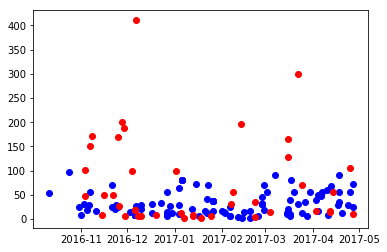

the score is:  7.259953161592506


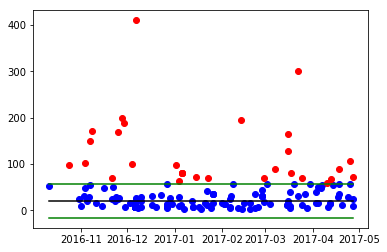

The total score is:  39.1100702576


In [30]:
total_score = (benfords(featuresdf['value'], show=True) + lof(featuresdf['value'], featuresdf['date'], show=True) + control_chart(featuresdf['value'], featuresdf['date'], show=True))/3
print('The total score is: ', total_score)